## Loading Images and resizing

In [1]:
import os
from PIL import Image
import numpy as np

In [2]:
imgs = []
for file in os.listdir('images/'):
    img = Image.open('images/'+file)
    img = img.resize((64,64))
    imgs.append(np.array(img))

In [3]:
data = np.array(imgs)
data = np.expand_dims(data,axis=3)
data.shape

(24, 64, 64, 1)

## Preprocess images with CLAHE

In [4]:
import cv2
def preprocess(img):
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    cl = clahe.apply(l)
    limg = cv2.merge((cl,a,b))
    final = cv2.cvtColor(limg, cv2.COLOR_LAB2RGB)
    return final

data = np.array([preprocess(img) for img in data])
data.shape

(24, 64, 64, 3)

### Load Target Labels

In [5]:
import pandas as pd
target = pd.read_csv('meanvb.csv')
target = target['mean_vb']
target.head(5)

0    0.353
1    0.418
2    0.145
3    0.209
4    0.365
Name: mean_vb, dtype: float64

In [6]:
data = data.copy()
target = target.copy()

In [7]:
x_train = data[:20]
y_train = target[:20]

x_test = data[20:]
y_test = target[20:]

## CNN Model

In [12]:
import tensorflow as tf
from tensorflow import keras
from keras.backend import sum,square,mean,epsilon

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='linear')
])

def r2_score(y_true,y_pred):
    u = sum(square(y_true-y_pred))
    v = sum(square(y_true-mean(y_true)))
    return (1-u/(v+epsilon()))

# Compile the model
model.compile(optimizer='adam', loss=['mean_squared_error','mean_absolute_error'], metrics=[r2_score])

# Train the model
history = model.fit(x_train, y_train, epochs=200)

Epoch 1/200
1/1 [==============================] - 10s 10s/step - loss: 13.2612 - r2_score: -1124.0049
Epoch 2/200
1/1 [==============================] - 0s 99ms/step - loss: 29968.4941 - r2_score: -2542363.7500
Epoch 3/200
1/1 [==============================] - 0s 93ms/step - loss: 638.5500 - r2_score: -54170.1250
Epoch 4/200
1/1 [==============================] - 0s 78ms/step - loss: 151.4322 - r2_score: -12845.6846
Epoch 5/200
1/1 [==============================] - 0s 88ms/step - loss: 85.8833 - r2_score: -7284.8755
Epoch 6/200
1/1 [==============================] - 0s 89ms/step - loss: 36.0855 - r2_score: -3060.3013
Epoch 7/200
1/1 [==============================] - 0s 82ms/step - loss: 0.7727 - r2_score: -64.5519
Epoch 8/200
1/1 [==============================] - 0s 68ms/step - loss: 55.7866 - r2_score: -4731.6338
Epoch 9/200
1/1 [==============================] - 0s 79ms/step - loss: 0.6402 - r2_score: -53.3141
Epoch 10/200
1/1 [==============================] - 0s 80ms/step - lo

1/1 [==============================] - 0s 101ms/step - loss: 4.8339e-05 - r2_score: 0.9959
Epoch 162/200
1/1 [==============================] - 0s 128ms/step - loss: 4.5215e-05 - r2_score: 0.9962
Epoch 163/200
1/1 [==============================] - 0s 100ms/step - loss: 4.1765e-05 - r2_score: 0.9965
Epoch 164/200
1/1 [==============================] - 0s 98ms/step - loss: 3.6567e-05 - r2_score: 0.9969
Epoch 165/200
1/1 [==============================] - 0s 81ms/step - loss: 3.3269e-05 - r2_score: 0.9972
Epoch 166/200
1/1 [==============================] - 0s 71ms/step - loss: 3.1124e-05 - r2_score: 0.9974
Epoch 167/200
1/1 [==============================] - 0s 83ms/step - loss: 2.7536e-05 - r2_score: 0.9977
Epoch 168/200
1/1 [==============================] - 0s 90ms/step - loss: 2.4482e-05 - r2_score: 0.9979
Epoch 169/200
1/1 [==============================] - 0s 94ms/step - loss: 2.2991e-05 - r2_score: 0.9980
Epoch 170/200
1/1 [==============================] - 0s 93ms/step - loss: 2

##### Save the Model

In [9]:
model.save("surface_model_24IMG.h5")

#### Plot Accuracy

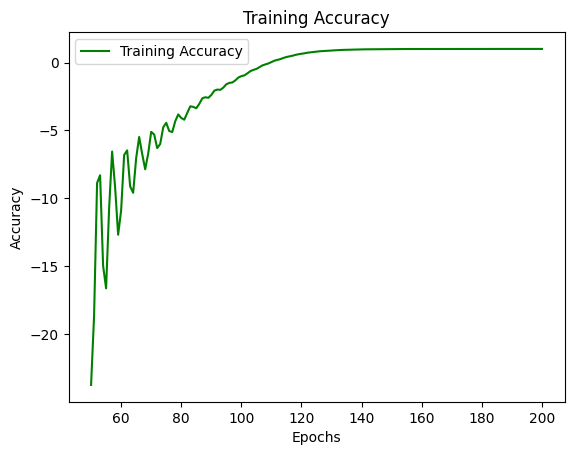

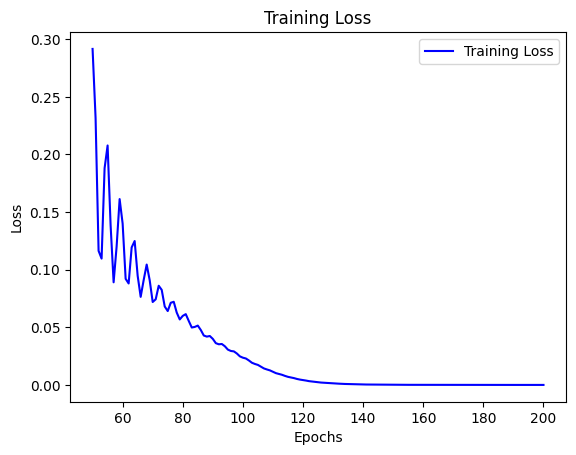

In [14]:
import matplotlib.pyplot as plt

acc = history.history['r2_score']
acc = acc[49:201]
epochs = range(50,201)
plt.plot(epochs, acc, 'g', label='Training Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

loss = history.history['loss']
loss = loss[49:201]
epochs = range(50,201)
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Extracting features using CNN 

In [11]:
from keras.models import load_model
model = load_model("surface_model_24IMG.h5",custom_objects={"r2_score": r2_score})

In [12]:
cnn_features = model.predict(data)
print(cnn_features.shape)
cnn_features = cnn_features.reshape(cnn_features.shape[0], -1)
print(cnn_features.shape)

1/1 [==============================] - 4s 4s/step
(24, 1)
(24, 1)


## Spliting training and testing data in 80:20 ratio

In [14]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(cnn_features,target,test_size=0.2,random_state=42)
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((19, 1), (5, 1), (19,), (5,))

# MODEL BUILDING

### Decision Tree

In [15]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
from math import sqrt

dt_model = DecisionTreeRegressor()
dt_model.fit(x_train, y_train)

DecisionTreeRegressor()

In [16]:
dt_predictions = dt_model.predict(x_test)
print("R2 score:", r2_score(y_test, dt_predictions))
print("Mean Absolute Error:", mean_absolute_error(y_test, dt_predictions))
print("Mean Squared Error:", mean_squared_error(y_test, dt_predictions))
print("RMSE :", sqrt(mean_squared_error(y_test, dt_predictions)))

R2 score: 0.9642829759501111
Mean Absolute Error: 0.008599999999999997
Mean Squared Error: 0.00011180000000000005
RMSE : 0.010573551910309044


### Support Vector Regressor (SVR)

In [17]:
from sklearn.svm import SVR
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
from math import sqrt

svr = SVR(kernel="poly",epsilon=0.001)
svr.fit(x_train, y_train)

SVR(epsilon=0.001, kernel='poly')

In [18]:
svr_predictions = svr.predict(x_test)
print("R2 score:", r2_score(y_test, svr_predictions))
print("Mean Absolute Error:", mean_absolute_error(y_test, svr_predictions))
print("Mean Squared Error:", mean_squared_error(y_test, svr_predictions))
print("RMSE :", sqrt(mean_squared_error(y_test, svr_predictions)))

R2 score: 0.6607224455884562
Mean Absolute Error: 0.02568162240168173
Mean Squared Error: 0.0010619930297168377
RMSE : 0.032588234528995855


### KNN

In [19]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
from math import sqrt

knn = KNeighborsRegressor()
knn.fit(x_train, y_train)

KNeighborsRegressor()

In [20]:
knn_predictions = knn.predict(x_test)
print("R2 score:", r2_score(y_test, knn_predictions))
print("Mean Absolute Error:", mean_absolute_error(y_test, knn_predictions))
print("Mean Squared Error:", mean_squared_error(y_test, knn_predictions))
print("RMSE :", sqrt(mean_squared_error(y_test, knn_predictions)))

R2 score: 0.975835101081095
Mean Absolute Error: 0.007319999999999982
Mean Squared Error: 7.563999999999992e-05
RMSE : 0.008697125962063556


### RandomForest

In [21]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
from math import sqrt

rf_model = RandomForestRegressor(n_estimators=100)
rf_model.fit(x_train, y_train)

RandomForestRegressor()

In [22]:
rf_predictions = rf_model.predict(x_test)
print("R2 score:", r2_score(y_test, rf_predictions))
print("Mean Absolute Error:", mean_absolute_error(y_test, rf_predictions))
print("Mean Squared Error:", mean_squared_error(y_test, rf_predictions))
print("RMSE :", sqrt(mean_squared_error(y_test, rf_predictions)))

R2 score: 0.9632699095253916
Mean Absolute Error: 0.009117999999999977
Mean Squared Error: 0.00011497106000000032
RMSE : 0.01072245587540468


In [23]:
import pickle
pickle.dump(rf_model,open("rf_model.pkl","wb"))

In [24]:
model = pickle.load(open("rf_model.pkl","rb"))

In [26]:
model.predict(x_test)[0]

0.2965799999999999

## TESTING

##### Ensemble Models

In [32]:
test = pd.DataFrame()
test['Original_meanVB'] = y_test.copy()
test['RF_pred'] = rf_predictions.copy()
test['DT_pred'] = dt_predictions.copy()
test['kNN_pred'] = knn_predictions.copy()
test['SVR_pred'] = svr_predictions.copy()

In [39]:
test

,Original_meanVB,RF_pred,DT_pred,kNN_pred,SVR_pred
8,0.284,0.28683,0.277,0.2786,0.251985
16,0.229,0.21198,0.209,0.2170,0.225759
0,0.353,0.34373,0.344,0.3528,0.291857
18,0.204,0.21034,0.209,0.2170,0.223449
11,0.211,0.21034,0.209,0.2170,0.223560


##### CNN

In [33]:
test_data = data[20:]
org = target[20:]
cnn_prediction = model.predict(test_data)

1/1 [==============================] - 0s 44ms/step


In [34]:
cnn_test = pd.DataFrame()
cnn_test['Org_meanVB'] = org.copy()
cnn_test['CNN_Pred'] = cnn_prediction.copy()

In [35]:
cnn_test

,Org_meanVB,CNN_Pred
20,0.322,0.320702
21,0.589,0.590716
22,0.231,0.227965
23,0.277,0.276243


## Accuracy plots

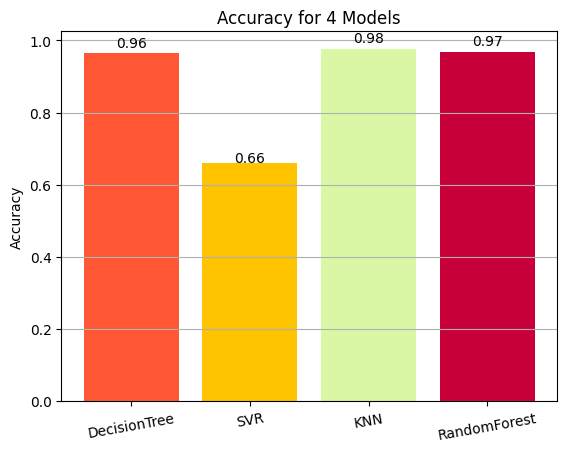

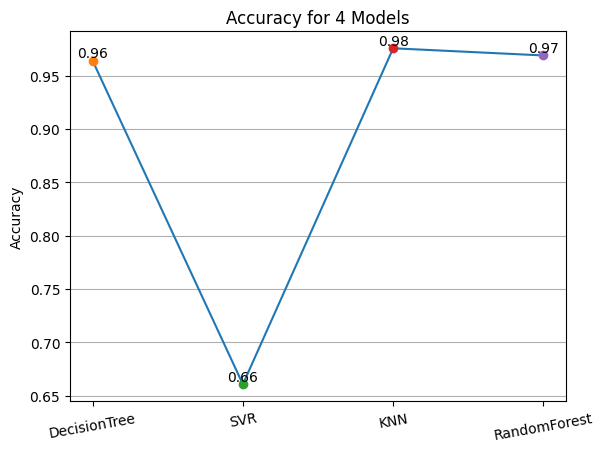

In [41]:
import matplotlib.pyplot as plt
import numpy as np

# Set the x-axis ticks and tick labels

models = ["DecisionTree","SVR","KNN","RandomForest"]
accuracy = [r2_score(y_test, dt_predictions), r2_score(y_test, svr_predictions),r2_score(y_test, knn_predictions),r2_score(y_test, rf_predictions)]
x_ticks = np.arange(len(models))
x_tick_labels = models

# Set the colors for the bars
colors = ['#FF5733', '#FFC300', '#DAF7A6', '#C70039']

# Create the bar plot
fig, ax = plt.subplots()
rects = ax.bar(x_ticks, accuracy, color=colors)

# Add labels, title, and gridlines
ax.set_xticks(x_ticks)
ax.set_xticklabels(x_tick_labels)
plt.xticks(rotation=10)
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy for 4 Models')
ax.grid(axis='y')

# Add the value labels to the bars
for i, rect in enumerate(rects):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2., 1.05 * height,
            f"{accuracy[i]:.2f}",
            ha='center', va='top')
plt.show()


# Create the line chart
fig, ax = plt.subplots()
ax.plot(x_ticks, accuracy)

# Add labels, title, and gridlines
ax.set_xticks(x_ticks)
plt.xticks(rotation=10)
ax.set_xticklabels(x_tick_labels)
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy for 4 Models')
ax.grid(axis='y')

# Add markers and value labels to the data points
for i, loss in enumerate(accuracy):
    ax.plot(i, loss, marker='o')
    ax.text(i, loss, f"{loss:.2f}", ha='center', va='bottom')

plt.show()

## MAE Plots

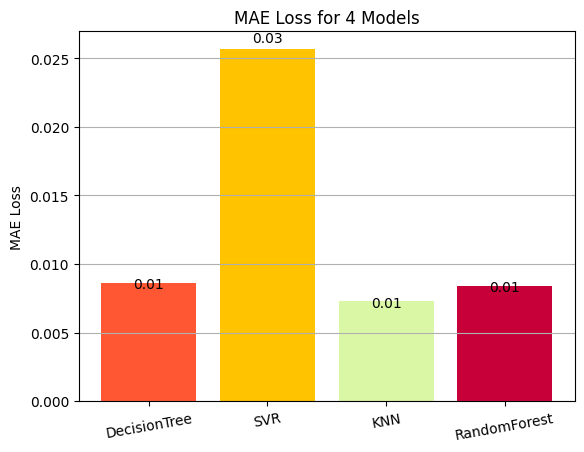

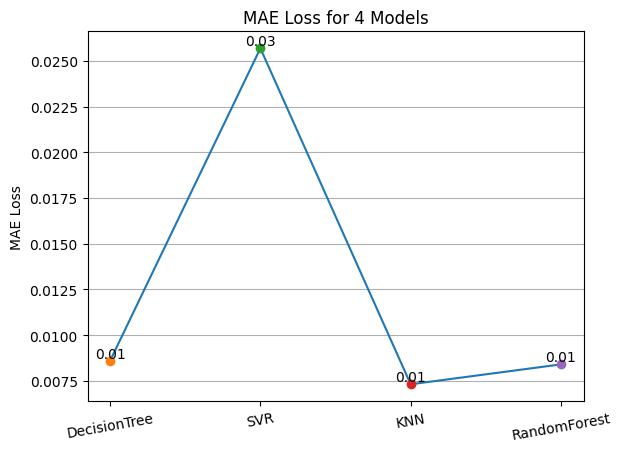

In [45]:
import matplotlib.pyplot as plt
import numpy as np

# Set the x-axis ticks and tick labels

models = ["DecisionTree","SVR","KNN","RandomForest"]
loss = [mean_absolute_error(y_test, dt_predictions), mean_absolute_error(y_test, svr_predictions),mean_absolute_error(y_test, knn_predictions),mean_absolute_error(y_test, rf_predictions)]
x_ticks = np.arange(len(models))
x_tick_labels = models

# Set the colors for the bars
colors = ['#FF5733', '#FFC300', '#DAF7A6', '#C70039']

# Create the bar plot
fig, ax = plt.subplots()
rects = ax.bar(x_ticks, loss, color=colors)

# Add labels, title, and gridlines
ax.set_xticks(x_ticks)
ax.set_xticklabels(x_tick_labels)
plt.xticks(rotation=10)
ax.set_ylabel('MAE Loss')
ax.set_title('MAE Loss for 4 Models')
ax.grid(axis='y')

# Add the value labels to the bars
for i, rect in enumerate(rects):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2., 1.05 * height,
            f"{loss[i]:.2f}",
            ha='center', va='top')
plt.show()


# Create the line chart
fig, ax = plt.subplots()
ax.plot(x_ticks, loss)

# Add labels, title, and gridlines
ax.set_xticks(x_ticks)
plt.xticks(rotation=10)
ax.set_xticklabels(x_tick_labels)
ax.set_ylabel('MAE Loss')
ax.set_title('MAE Loss for 4 Models')
ax.grid(axis='y')

# Add markers and value labels to the data points
for i, loss in enumerate(loss):
    ax.plot(i, loss, marker='o')
    ax.text(i, loss, f"{loss:.2f}", ha='center', va='bottom')

plt.show()

## MSE Plots

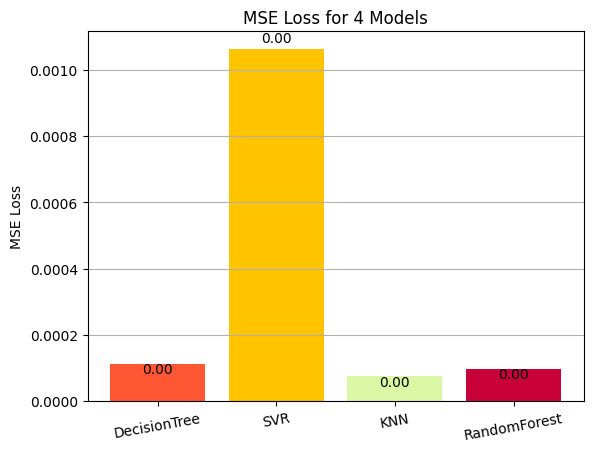

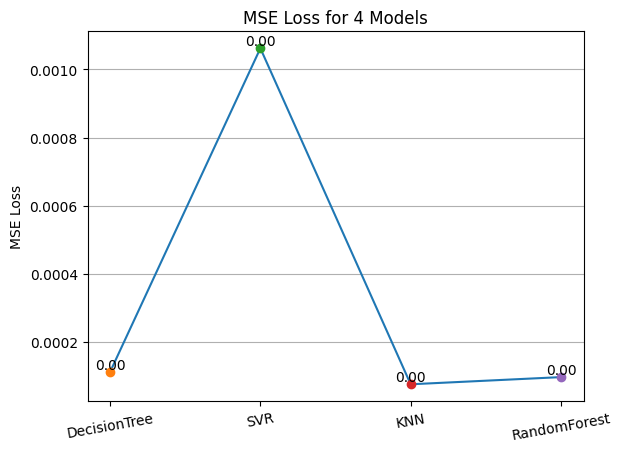

In [46]:
import matplotlib.pyplot as plt
import numpy as np

# Set the x-axis ticks and tick labels

models = ["DecisionTree","SVR","KNN","RandomForest"]
loss = [mean_squared_error(y_test, dt_predictions), mean_squared_error(y_test, svr_predictions),mean_squared_error(y_test, knn_predictions),mean_squared_error(y_test, rf_predictions)]
x_ticks = np.arange(len(models))
x_tick_labels = models

# Set the colors for the bars
colors = ['#FF5733', '#FFC300', '#DAF7A6', '#C70039']

# Create the bar plot
fig, ax = plt.subplots()
rects = ax.bar(x_ticks, loss, color=colors)

# Add labels, title, and gridlines
ax.set_xticks(x_ticks)
ax.set_xticklabels(x_tick_labels)
plt.xticks(rotation=10)
ax.set_ylabel('MSE Loss')
ax.set_title('MSE Loss for 4 Models')
ax.grid(axis='y')

# Add the value labels to the bars
for i, rect in enumerate(rects):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2., 1.05 * height,
            f"{loss[i]:.2f}",
            ha='center', va='top')
plt.show()


# Create the line chart
fig, ax = plt.subplots()
ax.plot(x_ticks, loss)

# Add labels, title, and gridlines
ax.set_xticks(x_ticks)
plt.xticks(rotation=10)
ax.set_xticklabels(x_tick_labels)
ax.set_ylabel('MSE Loss')
ax.set_title('MSE Loss for 4 Models')
ax.grid(axis='y')

# Add markers and value labels to the data points
for i, loss in enumerate(loss):
    ax.plot(i, loss, marker='o')
    ax.text(i, loss, f"{loss:.2f}", ha='center', va='bottom')

plt.show()

## RMSE PLOTS

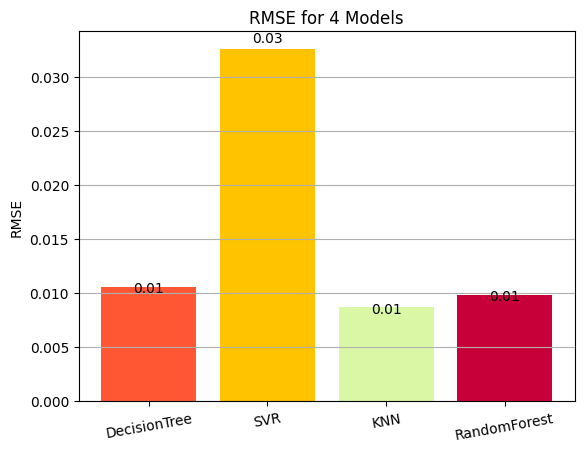

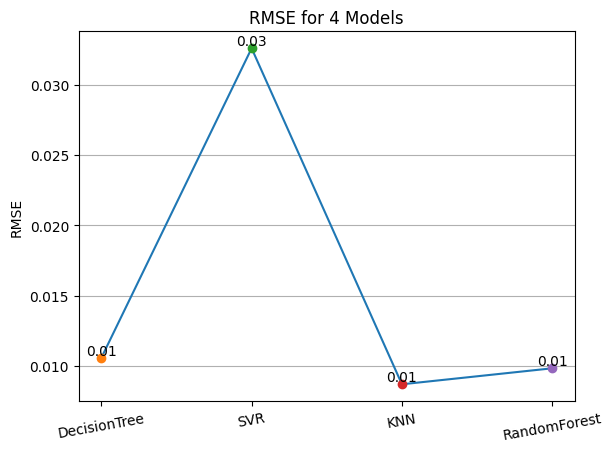

In [47]:
import matplotlib.pyplot as plt
import numpy as np

# Set the x-axis ticks and tick labels

models = ["DecisionTree","SVR","KNN","RandomForest"]
loss = [sqrt(mean_squared_error(y_test, dt_predictions)), sqrt(mean_squared_error(y_test, svr_predictions)),sqrt(mean_squared_error(y_test, knn_predictions)),sqrt(mean_squared_error(y_test, rf_predictions))]
x_ticks = np.arange(len(models))
x_tick_labels = models

# Set the colors for the bars
colors = ['#FF5733', '#FFC300', '#DAF7A6', '#C70039']

# Create the bar plot
fig, ax = plt.subplots()
rects = ax.bar(x_ticks, loss, color=colors)

# Add labels, title, and gridlines
ax.set_xticks(x_ticks)
ax.set_xticklabels(x_tick_labels)
plt.xticks(rotation=10)
ax.set_ylabel('RMSE')
ax.set_title('RMSE for 4 Models')
ax.grid(axis='y')

# Add the value labels to the bars
for i, rect in enumerate(rects):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2., 1.05 * height,
            f"{loss[i]:.2f}",
            ha='center', va='top')
plt.show()


# Create the line chart
fig, ax = plt.subplots()
ax.plot(x_ticks, loss)

# Add labels, title, and gridlines
ax.set_xticks(x_ticks)
plt.xticks(rotation=10)
ax.set_xticklabels(x_tick_labels)
ax.set_ylabel('RMSE')
ax.set_title('RMSE for 4 Models')
ax.grid(axis='y')

# Add markers and value labels to the data points
for i, loss in enumerate(loss):
    ax.plot(i, loss, marker='o')
    ax.text(i, loss, f"{loss:.2f}", ha='center', va='bottom')

plt.show()

In [27]:
pip list

Package                      Version
---------------------------- ------------------
absl-py                      1.4.0
aiohttp                      3.8.4
aioice                       0.9.0
aiortc                       1.5.0
aiosignal                    1.3.1
altair                       4.2.2
antlr4-python3-runtime       4.9.3
array-record                 0.2.0
asttokens                    2.0.5
astunparse                   1.6.3
async-timeout                4.0.2
attrs                        22.2.0
av                           10.0.0
backcall                     0.2.0
backports.zoneinfo           0.2.1
black                        23.1.0
blinker                      1.5
branca                       0.6.0
cachetools                   5.3.0
centroid-tracker             0.0.9
certifi                      2022.12.7
cffi                         1.15.1
chardet                      5.1.0
charset-normalizer           3.0.1
click                        8.0.4
cloudpickle                  2.2.1